In [ ]:
!nvidia-smi

Mon Nov  9 13:23:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* @file NLP進階 / Seq2seq_with_attention
  * @brief Seq2seq_with_attention 模型實作 

  * 此份程式碼是以教學為目的，附有完整的架構解說。

  * @author 人工智慧科技基金會 AI 工程師 - 康文瑋
  * Email: run963741@aif.tw
  * Resume: https://www.cakeresume.com/run963741

  * 最後更新日期: 2020/11/13

# Seq2seq with attention mechanism

在 2014 年末，Bahdanau 等人提出了[注意力機制 (Attention mechanism)](https://arxiv.org/abs/1409.0473)，大幅度提升 `Seq2seq` 在機器翻譯上的表現，亦使得深度學習領域向前邁一大步，現在許多知名的模型 (CNN 方面、RNN 方面) 都是以此為基礎進行設計，甚至是目前自然語言處理最強模型 `Transformer` 也是以此為思想進行設計的。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=19OpGD0XFy1W-IOmBaPOMfv195vU-rr4O' width="800"/>
<figcaption></figcaption></center>
</figure>

# Environment

#### - Tensorflow 2.3.0
#### - python3.7

# 載入套件

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow as tf
import os
import tqdm
import unicodedata
import re
import io
from pprint import pprint
from sklearn.model_selection import train_test_split

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

os.chdir('/content/drive/Shared drives/類技術班教材/標準版/NLP進階/Seq2seq 系列模型/Seq2seq_with_attention')
print(tf.__version__)

2.3.0


# 建立資料夾路徑

`en_vocab_file`: 儲存英文字典 (vocabulary) 路徑

`sp_vocab_file`: 儲存西文字典 (vocabulary) 路徑

`checkpoint_path`: 儲存模型路徑

`download_dir`: 資料儲存路徑

In [ ]:
output_dir = "nmt_seq2seq_with_attention"
en_vocab_file = os.path.join(output_dir, "en_vocab")
sp_vocab_file = os.path.join(output_dir, "sp_vocab")
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# 下載 `Tensorflow` 範例資料集

下載英文和西班牙文的範例資料集。

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True, cache_dir = download_dir)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

print('--'*20)
print('資料路徑: ', path_to_file)

----------------------------------------
資料路徑:  tensorflow-datasets/downloads/datasets/spa-eng/spa.txt


# 資料前處理

## 字串處理

在 Unicode 中，某些字符能夠用多種合法的底層編碼，例如在以下範例中，西班牙文字 $\tilde{n}$ 可以由兩種編碼來表示，這種情況會導致後續建立語言模型時產生問題，所以我們要使用 `unicodedata` 將文字做標準化。

In [ ]:
s1 = 'Spicy Jalape\u00f1o'
s2 = 'Spicy Jalapen\u0303o'

print('s1: ', s1)
print('s2: ', s2)
print('s1 和 s2 是否一樣: ', s1 == s2)

s1:  Spicy Jalapeño
s2:  Spicy Jalapeño
s1 和 s2 是否一樣:  False


### `unicodedata` 標準化範例

In [ ]:
# https://python3-cookbook.readthedocs.io/zh_CN/latest/c02/p09_normalize_unicode_text_to_regexp.html
s1_normalized = unicodedata.normalize('NFD', s1)
s2_normalized = unicodedata.normalize('NFD', s2)

print('s1: ', s1_normalized)
print('s2: ', s2_normalized)
print('s1 和 s2 是否一樣: ', s1_normalized == s2_normalized)

s1:  Spicy Jalapeño
s2:  Spicy Jalapeño
s1 和 s2 是否一樣:  True


## 字串處理函數

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn') # Mn 判斷是否為 Nonspacing

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 正則表達式: https://www.runoob.com/regexp/regexp-syntax
  # http://ccckmit.wikidot.com/regularexpression
  w = re.sub(r"([?.!,¿])", r"\1", w)
  w = re.sub(r'[" "]+', " ", w)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()
  return w

In [ ]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
  # 使用 /t 把英文和西文分開
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

## 讀取資料集

In [ ]:
en, sp = create_dataset(path_to_file, None)

In [ ]:
print(en[20])
print(sp[20])

wait.
esperen.


## 切割訓練集 (Training) 和測試集 (Testing)

In [ ]:
en_train, en_test, sp_train, sp_test = train_test_split(en, sp, test_size = 0.1, shuffle = True)

train_examples = tf.data.Dataset.from_tensor_slices((en_train, sp_train))
test_examples = tf.data.Dataset.from_tensor_slices((en_test, sp_test))

In [ ]:
print('Train size: ', len(en_train))
print('Test size: ', len(en_test))

Train size:  107067
Test size:  11897


In [ ]:
tmp_en, tmp_sp = next(iter(train_examples))

print('Input english: ', tmp_en)
print('Output spanish: ', tmp_sp)

Input english:  tf.Tensor(b'it was about money.', shape=(), dtype=string)
Output spanish:  tf.Tensor(b'era cuestion de dinero.', shape=(), dtype=string)


## 使用`tfds.deprecated.text.SubwordTextEncoder`載入與建立字典

* `.load_from_file`: 從路徑載入字典
* `.build_from_corpus`: 建立字典
* `.save_to_file`: 儲存字典

In [ ]:
%%time
try: 
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file) 
    print('Load English vocabulary: %s' % en_vocab_file)
except: 
    print('Build English vocabulary: %s' % en_vocab_file)
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for en, sp in train_examples),target_vocab_size = 2**13)
    tokenizer_en.save_to_file(en_vocab_file)

Load English vocabulary: nmt_seq2seq_with_attention/en_vocab
CPU times: user 38.4 ms, sys: 71 µs, total: 38.4 ms
Wall time: 42.4 ms


In [ ]:
%%time
try: 
    tokenizer_sp = tfds.deprecated.text.SubwordTextEncoder.load_from_file(sp_vocab_file) 
    print('Load Spanish vocfabulary: %s' % sp_vocab_file)
except: 
    print('Build Spanish vocabulary: %s' % sp_vocab_file)
    tokenizer_sp = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((sp.numpy() for en, sp in train_examples), target_vocab_size = 2**13)
    tokenizer_sp.save_to_file(sp_vocab_file)

Load Spanish vocfabulary: nmt_seq2seq_with_attention/sp_vocab
CPU times: user 31.3 ms, sys: 5.04 ms, total: 36.3 ms
Wall time: 36.7 ms


### 字典大小以及 `subword`

In [ ]:
print('English vocabulary size: ', tokenizer_en.vocab_size)
print('Spanish vocabulary size: ', tokenizer_sp.vocab_size)
print('-' * 30)
print('English subwords: ', tokenizer_en.subwords[:10])
print('Spanish subwords: ', tokenizer_sp.subwords[:10])

English vocabulary size:  8285
Spanish vocabulary size:  8040
------------------------------
English subwords:  ['i_', 'the_', 'to_', 'you_', 'tom_', 'a_', 't_', 'is_', 'he_', 's_']
Spanish subwords:  ['que_', 'de_', 'a_', 'el_', 'no_', 'la_', 'tom_', '¿', 'es_', 'en_']


### Example

英文的斷詞方式是以 `wordpiece` 進行斷詞。

In [ ]:
sample_string = 'Transformer is awesome.'

tokenized_string_token = tokenizer_en.encode(sample_string)
print ('Tokenized string token is \n{}'.format(tokenized_string_token))

print('-'*20)
tokenized_string = [tokenizer_en.decode([ts]) for ts in tokenized_string_token]
print('Tokenized srting is \n{}'.format(tokenized_string))

print('-'*20)
original_string = tokenizer_en.decode(tokenized_string_token)
print ('The original string: \n{}'.format(original_string))

assert original_string == sample_string

Tokenized string token is 
[8113, 2193, 8144, 6770, 8, 4405, 8075]
--------------------
Tokenized srting is 
['T', 'ran', 's', 'former ', 'is ', 'awesome', '.']
--------------------
The original string: 
Transformer is awesome.


## 添加`<BOS>`,`<EOS>`在句子頭尾

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=11_d2u6W8t3qi_T8x22jKQ-MYnBNM6-JW' width="500"/>
<figcaption>Auto Regressive</figcaption></center>
</figure>

Seq2seq 模型的訓練方式以及預測方式都是使用 Auto Regressive 的模式來進行，將當前時間點 $T_1$ 的預測值接在下一個時間點 $T_2$ 的後面，再輸入給模型，直到模型預測出 $<EOS>$ 為止。

* $<BOS>$: 全名為 Begin of sentence，因為第一個時間點 $T_1$ 翻譯時不可能馬上有正確答案，所以會統一輸入 $<BOS>$ ，例如上圖的要完整預測出 $文瑋助教真帥$，第一個時間點 $T_1$ 還沒有 $文$ 這個字，所以使用 $<BOS>$ 來作為輸入。

* $<EOS>$: 全名為 End of sentence，當模型預測出這個 token 時，就代表整個序列預測完畢，如果前處理沒有加上 $<EOS>$，模型就會永無止盡的預測下去。

In [ ]:
def encode(en_t, sp_t):
    """
    這邊將 `.vocab_size`視為`<BOS>`, `.vocab_size+1`視為`<EOS>`
    訓練集所有句子都需要進行這一步前處理
    """
    en_indics = [tokenizer_en.vocab_size] + tokenizer_en.encode(en_t.numpy()) + [tokenizer_en.vocab_size + 1]
    sp_indics = [tokenizer_sp.vocab_size] + tokenizer_sp.encode(sp_t.numpy()) + [tokenizer_sp.vocab_size + 1]

    return en_indics, sp_indics

In [ ]:
en_t, sp_t = next(iter(train_examples))
en_indics, sp_indics = encode(en_t, sp_t)

print('英文<BOS>: %d' % tokenizer_en.vocab_size)
print('英文<EOS>: %d' % (tokenizer_en.vocab_size + 1))
print('西文<BOS>: %d' % tokenizer_sp.vocab_size)
print('西文<EOS>: %d' % (tokenizer_sp.vocab_size + 1))

print('-' * 20)
print('Before encode: (two tensor):')
print(en_t)
print(sp_t)
print()
print('After encode: (two array): ')
print(en_indics)
print(sp_indics)

英文<BOS>: 8285
英文<EOS>: 8286
西文<BOS>: 8040
西文<EOS>: 8041
--------------------
Before encode: (two tensor):
tf.Tensor(b'it was about money.', shape=(), dtype=string)
tf.Tensor(b'era cuestion de dinero.', shape=(), dtype=string)

After encode: (two array): 
[8285, 13, 14, 59, 172, 8075, 8286]
[8040, 55, 5647, 2, 153, 7830, 8041]


### `tf.py_function`

在 Tensorflow 的訓練過程中，所有的計算過程都必須使用 `tf.` 來達成，當有某一些函數操作不涉及到 `tf.` 時，就必須使用 `tf.py_function` 來將函數納入 tensorflow 的計算流程裡面。

In [ ]:
# import traceback

# try:
#     train_examples.map(encode)
# except AttributeError:
#     traceback.print_exc()

In [ ]:
def tf_encode(en_t, sp_t):
    """
    使用 tf.py_function 將 encode 函數轉換為 tensorflow 的輸入與輸出
    """
    return tf.py_function(encode, [en_t, sp_t], [tf.int64, tf.int64])

tmp_dataset = train_examples.map(tf_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
en_indices, sp_indices = next(iter(tmp_dataset))

print('After tf_encode: (two tensor)')
print(en_indices)
print(sp_indices)

After tf_encode: (two tensor)
tf.Tensor([8285   13   14   59  172 8075 8286], shape=(7,), dtype=int64)
tf.Tensor([8040   55 5647    2  153 7830 8041], shape=(7,), dtype=int64)


## 限制句子長度

為了加快訓練速度，使用`tf.logical`限制句子長度，並使用`.filter`過濾

In [ ]:
max_length = 50
def filter_max_length(en_t, sp_t, max_length = max_length):
    
    return tf.logical_and(tf.size(en_t) <= max_length,
                          tf.size(sp_t) <= max_length)

tmp_dataset = tmp_dataset.filter(filter_max_length)

## Padding

指定 `batch_size` 以及 `padding`，`padding` 會先檢查一個 `batch` 裡面的句子長度，不足最大長度的句子會補 `0` (`padding index`)，因為預設是補 `0` 的關係，所以字典中的  `word index` 必須從 `1` 開始計算，不然會跟 `padding index` 混淆。

In [ ]:
batch_size = 64
tmp_dataset = tmp_dataset.padded_batch(batch_size=batch_size, padded_shapes=([-1], [-1]))

en_batch, sp_batch = next(iter(tmp_dataset))

print('英文 batch: ')
print(en_batch)
print('-' * 15)
print('西文 batch: ')
print(sp_batch)

英文 batch: 
tf.Tensor(
[[8285   13   14 ...    0    0    0]
 [8285   56 2852 ...    0    0    0]
 [8285  134  153 ...    0    0    0]
 ...
 [8285    2 4507 ...    0    0    0]
 [8285    1   34 ...    0    0    0]
 [8285    1   49 ...    0    0    0]], shape=(64, 23), dtype=int64)
---------------
西文 batch: 
tf.Tensor(
[[8040   55 5647 ...    0    0    0]
 [8040   20 4360 ...    0    0    0]
 [8040 5266 7816 ...    0    0    0]
 ...
 [8040    6 6523 ...    0    0    0]
 [8040   38 4508 ...    0    0    0]
 [8040   13  105 ...    0    0    0]], shape=(64, 23), dtype=int64)


# 將`train_examples`與`val_examples`做同樣處理

* `train`:

 - `map(tf_encode)`: 將字串轉成index
 - `filter(filter_max_length)`:過濾長度
 - `cache()`: cache the dataset to memory to get a speedup while reading from it.
 - `shuffle(buffer_size)`: 打亂buffer裡的資料，確保隨機
 - `padded_batch(batch_size, padded_shapes=([-1],[-1]))`: padding長度 

Tensor-core pipeline: https://www.tensorflow.org/guide/performance/datasets?hl=zh_cn

In [ ]:
max_length = 50
batch_size = 64
buffer_size = 15000

train_dataset = (train_examples
                 .map(tf_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                 .filter(filter_max_length)
                 .cache()
                 .shuffle(buffer_size)
                 .padded_batch(batch_size, padded_shapes=([-1],[-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (test_examples
               .map(tf_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .filter(filter_max_length)
               .padded_batch(batch_size, padded_shapes=([-1], [-1])))

In [ ]:
%%time
en_batch, sp_batch = next(iter(train_dataset))

print('英文 batch tensor: ')
print(en_batch)
print('-' * 20)
print('西文 batch tensor: ')
print(sp_batch)

英文 batch tensor: 
tf.Tensor(
[[8285  202 1115 ...    0    0    0]
 [8285    1   18 ...    0    0    0]
 [8285  105  684 ...    0    0    0]
 ...
 [8285   55    4 ...    0    0    0]
 [8285    1   18 ...    0    0    0]
 [8285    1  294 ...    0    0    0]], shape=(64, 23), dtype=int64)
--------------------
西文 batch tensor: 
tf.Tensor(
[[8040   14  851 ...    0    0    0]
 [8040   46    1 ...    0    0    0]
 [8040   15   71 ...    0    0    0]
 ...
 [8040    8   52 ...    0    0    0]
 [8040    5   46 ...    0    0    0]
 [8040  967    1 ...    0    0    0]], shape=(64, 22), dtype=int64)
CPU times: user 7.38 s, sys: 1.23 s, total: 8.61 s
Wall time: 5.33 s


# Seq2seq with attention mechanism


要理解Attention的想法，推薦閱讀:

https://medium.com/ai-academy-taiwan/attention-mechanism-fad735db3c2c


以下程式碼分為三個主要部分:

1. `Encoder`: 通常使用`RNN`系列的模型，例如`RNN`、`LSTM`、`GRU`等等，頂多再加上雙向的架構，所有的`RNN`模型在每個`timestep`都會產生一個`hidden state`，這個`hidden state`會準備給`Decoder`進行`attention`。

2. `Attention layer`: 連接`Encoder`與`Decoder`之間的計算`attention`方式，這裡計算`attention`方式有很多種，基本上就是圍繞在兩個`hidden state`之間的attention計算方式，有`concatenation`、`fully connection`等等，之後產生`context vector`$c_t$。

3. `Decoder`: 負責組合`Encoder`與`Decoder`的`hidden state`，這邊也有許多種組合方式

## 基本參數設置

In [ ]:
vocab_inp_size = tokenizer_en.vocab_size + 2
vocab_tar_size = tokenizer_sp.vocab_size + 2

embedding_dim = 512
units = 1024
batch_size = 64
epochs = 20
learning_rate = 0.001

## Encoder

`Encoder`就是`RNN`，需要注意的是要將每個`timestep`都進行輸出，這裡我們使用`LSTM`。

### LSTM parameters

 - `return_sequences`：是否返回所有的`timestep`的`hidden_state`。
 - `return_state`：是否返回最後一個`timestep`的`cell_state`，注意只有`LSTM`有`cell_state`，其餘像`RNN,GRU`是沒有`cell_state`的。

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_inp_size, embedding_dim, units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim)
        self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        
    def __call__(self, x):
        """
        LSTM需要initial_state與initial_cell兩種初始值，這邊都使用同一個initial_hidden_state作為初始值
        若使用GRU則只需要一個initial_state即可
        """
        x = self.embedding(x)
        states, last_state, cell_memory = self.lstm(x)
        return states, last_state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)

initial_hidden = encoder.initialize_hidden_state()
states, last_state = encoder(en_batch)
print('Encoder hidden state for each timestep: ',states.shape) # (batch_size, sequence_length, units)
print('Encoder last hidden state: ',last_state.shape) # (batch_size, sequence_length, units)

Encoder hidden state for each timestep:  (64, 23, 1024)
Encoder last hidden state:  (64, 1024)


## Attention mechanism

這裡實作 `Bahdanau attention` 的架構，基本上就是圍繞在編碼器的 `hidden state` $\bar{h}_s$ 與 解碼器的 `hidden state` $h_t$:

1. [NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, Bahdanau et al.](https://arxiv.org/pdf/1409.0473.pdf)

 - 這篇論文使用 `fully connection` 來計算 $\bar{h}_s$ 與 $h_t$ 的`attention`。
 
 
$$
\Large{\mathrm{score}(h_t,\bar{h}_s)=v_a^T\tanh(w_1h_t+w_2\bar{h}_s)} \\
\Large{v_a, h_t, \bar{h}_s, w1,w2\in \{R^d, R^d, R^d, R^{d\times d}, R^{d\times d}\}}
$$
 

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1cH_2KjFglNNbY7oyXYq7DrRiOIPqt7aT' width="400"/>
<figcaption>Attention mechanism</figcaption></center>
</figure>

計算完每個位置的 `attention score` $A\in R^N$ 之後，再將 `attention score` 與編碼器的 $\bar{h}_s\in R^{N\times d}$ 做線性組合: 

$$
C = \sum_{i=1}^NA_i\bar{h}_{s_i} \in R^d
$$

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)
    
    def __call__(self, query, keys):
        """
        配合上圖，命名 query 和 keys 為了與 transformer 相互比較
        query: 為 decoder 的 hidden state, 就是 hs, (batch_size, units)
        keys: 為 encoder 每個 hidden state, 就是 ht, (batch_size, sequence_length, units)
        """
        query = tf.expand_dims(query, axis=1)
        """
        Bahdanau Attention
        輸出為(batch_size, sequence_length, 1), encoder 每個 ht 都有一個 score
        """
        score = self.v(tf.nn.tanh(self.w1(keys) + self.w2(query)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        """
        在這邊就是將 attention_weights 與 keys 做線性組合得到 context vector c
        """
        context_vector = tf.reduce_sum(attention_weights * keys, axis=1)
        
        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(last_state, states)
print('context_vector shape: ', context_vector.shape)
print('attention_weights shape: ', attention_weights.shape)

context_vector shape:  (64, 1024)
attention_weights shape:  (64, 23, 1)


還有其他計算 `attention score` 方式也陸續提出來，如下圖: 

* `dot`: 向量內積
* `general`: 中間放一個權重 $W_a$。
* `concat`: 將兩個向量 `concat` ($h=[h_t;\bar{h}_s]\in R^{2d}$)，接著乘以權重 $W_a\in R^{d\times 2d}$，然後通過 `tanh` ($\in R^{d}$)，在乘以權重 $v_a\in R^{d}$ 得到 `attention score` ($score(h_t,\bar{h}_s)={v_a}^\top h\in R$)。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1lRi8VxEVN9iBtVUOmmrtUs4KWyhj2OvQ' width="600"/>
<figcaption>Attention mechanism</figcaption></center>
</figure>

再後來有許多的論文都是以向量內積 `dot` 為主，因為內積不會增加任何參數量，而且表現也不錯，目前在自然語言處理領域中最強的架構 `Transformer` 中，就是使用內積來計算兩個詞向量的相似度。

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units, score_function = 'dot'):
        super().__init__()
        self.wa1 = tf.keras.layers.Dense(units) # for general
        self.wa2 = tf.keras.layers.Dense(units) # for concat
        self.va = tf.keras.layers.Dense(1) # for concat
        self.score_function = score_function
    def __call__(self, query, keys):

        # query shape == (batch, 1, hidden_size)
        query = tf.expand_dims(query, axis=1)

        if self.score_function == 'dot':
          score = tf.einsum('ijk,imk->ij', keys, query)
        elif self.score_function == 'general':
          score = tf.einsum('ijk,imk->ij', keys, self.wa1(query))
        elif self.score_function == 'concat':
          query = tf.broadcast_to(query, (query.shape[0], keys.shape[1], query.shape[2]))
          score = self.va(tf.nn.tanh(self.wa2(tf.concat([keys, query], axis=-1))))
          score = tf.squeeze(score, axis=2)

        attention_weights = tf.nn.softmax(score, axis=1)
        attention_weights = tf.expand_dims(attention_weights, axis=2)
        context_vector = tf.reduce_sum(attention_weights * keys, axis=1)
        
        return context_vector, attention_weights

In [ ]:
attention_layer = Attention(units, score_function = 'concat')
context_vector, attention_weights = attention_layer(last_state, states)
print('context_vector shape: ', context_vector.shape)
print('attention_weights shape: ', attention_weights.shape)

context_vector shape:  (64, 1024)
attention_weights shape:  (64, 23, 1)


## Decoder for Bahdanau

透過`Attention`得到`context vector`之後，`Decoder`的作用就是決定如何串接`Encoder`的`hidden state`以及進行輸出預測。

在 `Bahdanau attention` 中，是先把 `context vector` 與 `word embedding` 進行 `concat`，然後再通過 `lstm` 得到預測值。



$$
\Large{\tilde{h}=lstm([C;x]),\;C,x,\tilde{h}\in \{R^d,R^d,R^d\}} \\
\Large{\hat{y}=Dense(\tilde{h})\in R^{vocab\;size}}
$$

In [ ]:
class Decoder_Bahdanau(tf.keras.Model):
  def __init__(self, vocab_tar_size, embedding_dim, dec_units):
    super().__init__()
    # 同上式中的 x
    self.embedding = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim)
    # 同上式中的 lstm
    self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    # 同上式中的 Dense
    self.fc = tf.keras.layers.Dense(vocab_tar_size)

    # 同上式中計算 attention score C 的函數
    self.attention = BahdanauAttention(dec_units)

  def __call__(self, x, hidden, enc_output, score_function = None):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # hidden shape == (batch_size, hidden_size)
    # context vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, inp_len, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    # output shape == (batch_size, 1, dec_units)
    # state shape == (batch_size, dec_units)
    # cell_memory shape == (batch_size, dec_units)
    output, state, cell_memory = self.lstm(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.squeeze(output, axis=1)

    # output shape == (batch_size, vocab_size)
    logits = self.fc(output)

    return logits, state, attention_weights

### Decoder for Bahdanau attention

In [ ]:
decoder_Bahdanau = Decoder_Bahdanau(vocab_tar_size, embedding_dim, units)
logits, state, attention_weights = decoder_Bahdanau(sp_batch[:,-1:], initial_hidden, states)

print('logits shape: ', logits.shape) # (batch_size, vocab_tar_size)
print('last_state shape: ', state.shape) # (batch_size, dec_units)
print('attention_weights shape: ', attention_weights.shape) # (batch_size, sequence_length, 1)

logits shape:  (64, 8042)
last_state shape:  (64, 1024)
attention_weights shape:  (64, 23, 1)


## Decoder for other



這邊的作法與上面 `Decoder for other` 類似，差別只在於計算 `attention score` 的方式

In [ ]:
class Decoder_other(tf.keras.Model):
  def __init__(self, vocab_tar_size, embedding_dim, dec_units, score_function):
    super().__init__()
    # 同上式中的 x
    self.embedding = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim)
    # 同上式中的 lstm
    self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    # 同上式中的 Dense
    self.fc = tf.keras.layers.Dense(vocab_tar_size)

    # 同上式中計算 attention score C 的函數
    self.attention = Attention(dec_units, score_function)

  def __call__(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # hidden shape == (batch_size, hidden_size)
    # context vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, inp_len, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    # output shape == (batch_size, 1, dec_units)
    # state shape == (batch_size, dec_units)
    # cell_memory shape == (batch_size, dec_units)
    output, state, cell_memory = self.lstm(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.squeeze(output, axis=1)

    # output shape == (batch_size, vocab_size)
    logits = self.fc(output)

    return logits, state, attention_weights

### Decoder for other attention

In [ ]:
decoder_other = Decoder_other(vocab_tar_size, embedding_dim, units, score_function = 'dot')
logits, state, attention_weights = decoder_other(sp_batch[:,-1:], initial_hidden, states)

print('logits shape: ', logits.shape) # (batch_size, vocab_tar_size)
print('last_state shape: ', state.shape) # (batch_size, dec_units)
print('attention_weights shape: ', attention_weights.shape) # (batch_size, sequence_length, 1)

logits shape:  (64, 8042)
last_state shape:  (64, 1024)
attention_weights shape:  (64, 23, 1)


## Loss and metrics

這裏定義損失函數，當 `Decoder` 預測出每個位置的詞時需要計算損失，這邊使用分類任務的損失函數 `CategoricalCrossentropy`。

部分句子為因為 `padding` 而有許多的 `0`，但是那並不是真實的標籤，所以必須忽略 `padding` 位置的損失。


In [ ]:
def loss_function(real, pred):
    """
    Input:
    real: (batch_size, 1)
    pred: (batch_size, vocab_tar_size)
    
    Return: 
    mean loss for current batch
    
    mask: (batch_size, 1)
    因為一個batch中有些句子會提早出現padding(index為0)，不需要計算 padding 的 loss，這裏使用 mask 來記錄 padding 的 index
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    """
    from_logits: y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.
    reduction: the reduction schedule of output loss vectors. `https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/Reduction`
    """
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
    """
    loss_: (batch_size, 1)
    """
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # 只計算非padding的loss
    
    return tf.reduce_mean(loss_)

In [ ]:
real = tf.constant([[0.],[1.]], dtype=tf.float32)
pred = tf.constant([[0.3,0.2,0.5],[0,1,0]], dtype=tf.float32)

mean_loss = loss_function(real, pred)
print('mean loss for current batch: ', mean_loss.numpy())

mean loss for current batch:  0.42281893


## Optimizer

優化器通常會優先考慮 `Adam`。

近期亦有許多表現不錯的優化器被研究出來，例如 `RangerLars` 在圖像任務上表現上就比 `Adam` 還要好。

優化器表現可以參考: https://github.com/mgrankin/over9000

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
# radam = tfa.optimizers.RectifiedAdam()
# # ranger
# optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

## Checkpoints

這裏定義儲存模型的方式:

* `checkpoint_path`: 模型儲存路徑
* `ckpt`: 模型中的架構
* `ckpt_manager`: 模型儲存的策略，包含了架構 (`ckpt`), 路徑 (`checkpoint_path`), 儲存最近幾次 (`max_to_keep`)。

In [ ]:
# score_function = 'general'
model_name = 'checkpoints_seq2seq_with_Bah_attention'

encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)
decoder_Bahdanau = Decoder_Bahdanau(vocab_tar_size, embedding_dim, units)
# decoder_concat = Decoder_other(vocab_tar_size, embedding_dim, units, score_function)

checkpoint_path = os.path.join(output_dir, model_name)
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder_Bahdanau, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

## Train step

這邊設定輸入一個英文句子進行訓練的方式，大致上的步驟為:

1. 輸入句子給 `encoder` 獲得 `hidden state`，準備給 `decoder` 計算 `attention`。
2. 定義初始輸入 `<BOS>`。

**以下進入迴圈**

3. 使用 `<BOS>` 輸入給 `decoder` 獲得一個預測詞。
4. 預測詞與真實詞計算損失。
5. 使用 `tearch forcing` 策略，將真實詞丟回給模型繼續預測，而不是把預測詞丟回給模型。

**以上為迴圈**

6. 拿出模型所有參數以及損失，使用 `optimizer` 進行梯度下降。


In [ ]:
def train_step(inp, tar, decoder):

    loss = 0
    """
    使用 with tf.GradientTape() 來告訴 tensorflow 以下的執行過程都會涉及到梯度的更新
    """
    with tf.GradientTape() as tape:
        # 首先產生 encoder 所有的 hidden states
        states, last_state = encoder(inp)
        
        # 使用 encoder 的最後一步 last_state 作為 decoder 的 initial state
        hidden_state = last_state
        
        # 因為一開始還沒有正確答案，所以必須輸入給 decoder 一個起始的 token
        # tokenizer_sp.vocab_size: <BOS> token
        dec_input = tf.expand_dims([tokenizer_sp.vocab_size] * batch_size, axis=1)
        
        # auto-regressive 迴圈，每次預測出一個詞
        for t in range(1, tar.shape[1]):
            # decoder 進行預測 
            predictions, hidden_state, _ = decoder(dec_input, hidden_state, states)

            # 預測結果和標籤計算損失
            loss += loss_function(tar[:, t], predictions)
            
            # 使用 teacher forcing 策略，每次輸入給模型真實答案，而不是預測值，這樣做的原因是防止模型一直錯下去
            dec_input = tf.expand_dims(tar[:, t], axis=1)
    # 計算一個 batch 中的平均損失
    batch_loss = (loss / int(tar.shape[1]))

    # 拿出模型所有參數
    variables = encoder.trainable_variables + decoder.trainable_variables

    # 計算模型參數的 gradient
    gradients = tape.gradient(loss, variables)

    # Pre-normalized gradient
    # (gradients, _) = tf.clip_by_global_norm(gradients, clip_norm=1.0)

    # 使用 gradient 進行梯度下降
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

## Evaluation step

定義評估方式，輸入為英文句子，輸出為預測西文。

基本上與 `train_step` 雷同，差別在於兩個：

1. 沒有進行梯度下降
2. 當模型預測出 `<EOS>` 時，即停止預測。

In [ ]:
def evaluate(inp_sentence, decoder):
    
    # 輸入英文句子進行文字前處理
    inp_sentence = preprocess_sentence(inp_sentence)

    # 英文句子轉換為 token
    inp_tokenized = tokenizer_en.encode(inp_sentence)

    # 在英文句子前後加上 <BOS> 以及 <EOS>
    inp_id = [tokenizer_en.vocab_size] + inp_tokenized + [tokenizer_en.vocab_size+1]

    # 新增一個 batch_size 維度，符合模型輸入
    inp_id = tf.expand_dims(inp_id, axis=0)
    
    # 定義 decoder 輸入 <BOS>
    dec_inp = tf.expand_dims([tokenizer_sp.vocab_size] * inp_id.shape[0], axis=0)
    
    # 產生 encoder 所有的 hidden states
    states, last_state = encoder(inp_id)
    hidden_state = last_state
    
    # 紀錄預測結果
    preds_ids = list()
        
    # 紀錄每次預測值的注意力矩陣
    attn_plot = np.zeros((max_length, len(inp_tokenized) + 2))
    
    # 此迴圈開始進行預測，直到 max_length 或是預測出 <EOS> 就停止
    for t in range(max_length):
        # decoder 進行預測
        preds, hidden_state, attention_weights = decoder(dec_inp, hidden_state, states)

        # 使用 argmax 挑出預測概率最高的 token
        preds_id = tf.argmax(preds[0], axis=0).numpy()
        
        # 新增一個 `batch_size` 維度，符合模型輸入
        dec_inp = tf.expand_dims([preds_id], axis=0)
        
        # 紀錄預測結果
        preds_ids.append(preds_id)

        # attention_weights 的維度為 (1, predicted_seq_len, 1)，使用 tf.squeeze 將維度為 1 拿掉
        attention_weights = tf.squeeze(attention_weights).numpy()
        
        # 紀錄注意力矩陣
        attn_plot[t] = attention_weights

        # 如果預測出 <BOS> 就跳出此迴圈
        if preds_id == tokenizer_sp.vocab_size + 1:
          attn_plot = attn_plot[:t+1, :]
          break
          

    # 去除非 <BOS> 和 <EOS> 的 token
    preds_ids = [ids for ids in preds_ids if ids < tokenizer_sp.vocab_size]
    
    # 將 token 還原成字串
    preds_sent = tokenizer_sp.decode(preds_ids)

    return preds_sent, inp_sentence, attn_plot

## Training

開始訓練過程

In [ ]:
for epoch in tqdm.tqdm(tf.range(epochs)):
    start = time.time()
    
    total_loss = 0
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        # 如果輸入的句子數量不滿一個 `batch_size`，就複製最後一個句子直到達到 `batch_size`
        if inp.shape[0] != batch_size:
            repeats = batch_size - inp.shape[0]
            
            rep_inp = tf.convert_to_tensor(np.repeat(inp[-1:,:], repeats=repeats, axis=0))
            inp = tf.concat([inp, rep_inp], axis=0)
            
            rep_tar = tf.convert_to_tensor(np.repeat(tar[-1:,:], repeats=repeats, axis=0))
            tar = tf.concat([tar,rep_tar], axis=0)
            
        batch_loss = train_step(inp, tar, decoder_Bahdanau)
        
        total_loss += batch_loss
        
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            
    if (epoch + 1) % 2 == 0:
        print('Save Model!')
        ckpt_manager.save()

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / (batch+1)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    result, sentence, attention_plot = evaluate('I am hungry.', decoder_Bahdanau)
    print('Input: %s' % (sentence))
    print('Predicted translation: %s' % (result))
    print('-'*20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 4.7441
Epoch 1 Batch 50 Loss 3.3628
Epoch 1 Batch 100 Loss 1.7734
Epoch 1 Batch 150 Loss 3.0198
Epoch 1 Batch 200 Loss 2.7325
Epoch 1 Batch 250 Loss 2.6785
Epoch 1 Batch 300 Loss 1.2412
Epoch 1 Batch 350 Loss 1.8202
Epoch 1 Batch 400 Loss 2.2067
Epoch 1 Batch 450 Loss 2.2708
Epoch 1 Batch 500 Loss 1.9765
Epoch 1 Batch 550 Loss 2.4701
Epoch 1 Batch 600 Loss 2.5842
Epoch 1 Batch 650 Loss 1.9155
Epoch 1 Batch 700 Loss 2.7559
Epoch 1 Batch 750 Loss 2.0711
Epoch 1 Batch 800 Loss 1.9349
Epoch 1 Batch 850 Loss 2.1684
Epoch 1 Batch 900 Loss 2.1855
Epoch 1 Batch 950 Loss 2.0649
Epoch 1 Batch 1000 Loss 2.3459
Epoch 1 Batch 1050 Loss 1.7917
Epoch 1 Batch 1100 Loss 2.0473
Epoch 1 Batch 1150 Loss 2.0277
Epoch 1 Batch 1200 Loss 2.2901
Epoch 1 Batch 1250 Loss 1.7167
Epoch 1 Batch 1300 Loss 2.2421
Epoch 1 Batch 1350 Loss 1.8546
Epoch 1 Batch 1400 Loss 1.8268
Epoch 1 Batch 1450 Loss 2.2387
Epoch 1 Batch 1500 Loss 1.3256
Epoch 1 Batch 1550 Loss 2.2229
Epoch 1 Batch 1600 Loss 2.1061


  5%|▌         | 1/20 [14:01<4:26:37, 841.95s/it]

Epoch 1 Loss 2.1641
Time taken for 1 epoch 841.9200496673584 sec

Input: i am hungry.
Predicted translation: el trabajo.
--------------------
Epoch 2 Batch 0 Loss 1.5350
Epoch 2 Batch 50 Loss 1.9693
Epoch 2 Batch 100 Loss 1.6483
Epoch 2 Batch 150 Loss 1.9267
Epoch 2 Batch 200 Loss 1.6363
Epoch 2 Batch 250 Loss 1.6256
Epoch 2 Batch 300 Loss 1.5858
Epoch 2 Batch 350 Loss 1.5216
Epoch 2 Batch 400 Loss 1.7056
Epoch 2 Batch 450 Loss 1.3708
Epoch 2 Batch 500 Loss 1.6856
Epoch 2 Batch 550 Loss 1.4339
Epoch 2 Batch 600 Loss 2.0021
Epoch 2 Batch 650 Loss 1.4917
Epoch 2 Batch 700 Loss 1.2657
Epoch 2 Batch 750 Loss 1.8400
Epoch 2 Batch 800 Loss 1.6991
Epoch 2 Batch 850 Loss 1.4902
Epoch 2 Batch 900 Loss 1.8422
Epoch 2 Batch 950 Loss 1.6912
Epoch 2 Batch 1000 Loss 1.6035
Epoch 2 Batch 1050 Loss 1.2278
Epoch 2 Batch 1100 Loss 1.2901
Epoch 2 Batch 1150 Loss 1.4783
Epoch 2 Batch 1200 Loss 1.3181
Epoch 2 Batch 1250 Loss 1.5265
Epoch 2 Batch 1300 Loss 1.5634
Epoch 2 Batch 1350 Loss 1.7758
Epoch 2 Batch

 10%|█         | 2/20 [27:54<4:11:43, 839.08s/it]

Epoch 2 Loss 1.5420
Time taken for 1 epoch 832.333865404129 sec

Input: i am hungry.
Predicted translation: yo me gusta.
--------------------
Epoch 3 Batch 0 Loss 1.3105
Epoch 3 Batch 50 Loss 1.3492
Epoch 3 Batch 100 Loss 1.4503
Epoch 3 Batch 150 Loss 1.2025
Epoch 3 Batch 200 Loss 1.3244
Epoch 3 Batch 250 Loss 1.1670
Epoch 3 Batch 300 Loss 1.3638
Epoch 3 Batch 350 Loss 1.3452
Epoch 3 Batch 400 Loss 1.0878
Epoch 3 Batch 450 Loss 0.9420
Epoch 3 Batch 500 Loss 1.0893
Epoch 3 Batch 550 Loss 0.9765
Epoch 3 Batch 600 Loss 1.2737
Epoch 3 Batch 650 Loss 0.6153
Epoch 3 Batch 700 Loss 0.9338
Epoch 3 Batch 750 Loss 0.9224
Epoch 3 Batch 800 Loss 1.0526
Epoch 3 Batch 850 Loss 1.0976
Epoch 3 Batch 900 Loss 1.3657
Epoch 3 Batch 950 Loss 1.0830
Epoch 3 Batch 1000 Loss 1.2769
Epoch 3 Batch 1050 Loss 1.1162
Epoch 3 Batch 1100 Loss 1.2388
Epoch 3 Batch 1150 Loss 0.9944
Epoch 3 Batch 1200 Loss 1.2259
Epoch 3 Batch 1250 Loss 0.7456
Epoch 3 Batch 1300 Loss 1.3174
Epoch 3 Batch 1350 Loss 1.3024
Epoch 3 Batch

 15%|█▌        | 3/20 [42:23<4:00:16, 848.05s/it]

Epoch 3 Loss 1.2383
Time taken for 1 epoch 868.9343054294586 sec

Input: i am hungry.
Predicted translation: yo tengo hambre.
--------------------
Epoch 4 Batch 0 Loss 1.1423
Epoch 4 Batch 50 Loss 1.1507
Epoch 4 Batch 100 Loss 1.3275
Epoch 4 Batch 150 Loss 1.0912
Epoch 4 Batch 200 Loss 0.9543
Epoch 4 Batch 250 Loss 1.1174
Epoch 4 Batch 300 Loss 1.3558
Epoch 4 Batch 350 Loss 1.1243
Epoch 4 Batch 400 Loss 1.1566
Epoch 4 Batch 450 Loss 1.1133
Epoch 4 Batch 500 Loss 0.9434
Epoch 4 Batch 550 Loss 1.1023
Epoch 4 Batch 600 Loss 1.2379
Epoch 4 Batch 650 Loss 0.9681
Epoch 4 Batch 700 Loss 0.9749
Epoch 4 Batch 750 Loss 1.0369
Epoch 4 Batch 800 Loss 1.0081
Epoch 4 Batch 850 Loss 0.7666
Epoch 4 Batch 900 Loss 0.7331
Epoch 4 Batch 950 Loss 0.7533
Epoch 4 Batch 1000 Loss 0.7551
Epoch 4 Batch 1050 Loss 0.9196
Epoch 4 Batch 1100 Loss 0.8241
Epoch 4 Batch 1150 Loss 0.9079
Epoch 4 Batch 1200 Loss 1.0138
Epoch 4 Batch 1250 Loss 0.9774
Epoch 4 Batch 1300 Loss 0.8068
Epoch 4 Batch 1350 Loss 1.0114
Epoch 4 

 20%|██        | 4/20 [56:56<3:48:08, 855.55s/it]

Epoch 4 Loss 1.0217
Time taken for 1 epoch 873.0477342605591 sec

Input: i am hungry.
Predicted translation: 
--------------------
Epoch 5 Batch 0 Loss 0.6686
Epoch 5 Batch 50 Loss 1.2373
Epoch 5 Batch 100 Loss 0.9820
Epoch 5 Batch 150 Loss 0.8753
Epoch 5 Batch 200 Loss 0.7323
Epoch 5 Batch 250 Loss 0.8457
Epoch 5 Batch 300 Loss 0.9094
Epoch 5 Batch 350 Loss 0.9550
Epoch 5 Batch 400 Loss 0.7145
Epoch 5 Batch 450 Loss 0.6454
Epoch 5 Batch 500 Loss 0.6815
Epoch 5 Batch 550 Loss 0.7755
Epoch 5 Batch 600 Loss 0.8278
Epoch 5 Batch 650 Loss 0.8903
Epoch 5 Batch 700 Loss 0.7700
Epoch 5 Batch 750 Loss 0.9878
Epoch 5 Batch 800 Loss 0.8537
Epoch 5 Batch 850 Loss 1.1014
Epoch 5 Batch 900 Loss 0.5695
Epoch 5 Batch 950 Loss 0.9733
Epoch 5 Batch 1000 Loss 0.6441
Epoch 5 Batch 1050 Loss 0.8283
Epoch 5 Batch 1100 Loss 0.8494
Epoch 5 Batch 1150 Loss 0.7057
Epoch 5 Batch 1200 Loss 0.8357
Epoch 5 Batch 1250 Loss 0.7523
Epoch 5 Batch 1300 Loss 0.5809
Epoch 5 Batch 1350 Loss 0.9643
Epoch 5 Batch 1400 Loss 

 25%|██▌       | 5/20 [1:11:31<3:35:20, 861.38s/it]

Epoch 5 Loss 0.8631
Time taken for 1 epoch 874.9329748153687 sec

Input: i am hungry.
Predicted translation: yo almorgre.
--------------------
Epoch 6 Batch 0 Loss 0.8127
Epoch 6 Batch 50 Loss 0.7125
Epoch 6 Batch 100 Loss 0.5591
Epoch 6 Batch 150 Loss 0.6523
Epoch 6 Batch 200 Loss 0.7366
Epoch 6 Batch 250 Loss 0.8859
Epoch 6 Batch 300 Loss 0.5649
Epoch 6 Batch 350 Loss 0.8791
Epoch 6 Batch 400 Loss 0.6826
Epoch 6 Batch 450 Loss 0.4820
Epoch 6 Batch 500 Loss 0.6892
Epoch 6 Batch 550 Loss 0.8404
Epoch 6 Batch 600 Loss 0.7758
Epoch 6 Batch 650 Loss 0.9210
Epoch 6 Batch 700 Loss 0.8253
Epoch 6 Batch 750 Loss 0.9925
Epoch 6 Batch 800 Loss 0.7112
Epoch 6 Batch 850 Loss 0.6810
Epoch 6 Batch 900 Loss 0.6295
Epoch 6 Batch 950 Loss 0.8210
Epoch 6 Batch 1000 Loss 0.7833
Epoch 6 Batch 1050 Loss 0.7486
Epoch 6 Batch 1100 Loss 0.4181
Epoch 6 Batch 1150 Loss 0.6546
Epoch 6 Batch 1200 Loss 0.6623
Epoch 6 Batch 1250 Loss 0.4918
Epoch 6 Batch 1300 Loss 0.6801
Epoch 6 Batch 1350 Loss 0.7406
Epoch 6 Batc

 30%|███       | 6/20 [1:26:05<3:21:51, 865.13s/it]

Epoch 6 Loss 0.7341
Time taken for 1 epoch 873.8347284793854 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 7 Batch 0 Loss 0.9143
Epoch 7 Batch 50 Loss 0.5199
Epoch 7 Batch 100 Loss 0.7036
Epoch 7 Batch 150 Loss 0.6401
Epoch 7 Batch 200 Loss 0.7591
Epoch 7 Batch 250 Loss 0.4830
Epoch 7 Batch 300 Loss 0.5039
Epoch 7 Batch 350 Loss 0.6833
Epoch 7 Batch 400 Loss 0.6490
Epoch 7 Batch 450 Loss 0.8525
Epoch 7 Batch 500 Loss 0.6689
Epoch 7 Batch 550 Loss 0.9067
Epoch 7 Batch 600 Loss 0.6431
Epoch 7 Batch 650 Loss 0.5993
Epoch 7 Batch 700 Loss 0.7194
Epoch 7 Batch 750 Loss 0.5073
Epoch 7 Batch 800 Loss 0.5265
Epoch 7 Batch 850 Loss 0.8995
Epoch 7 Batch 900 Loss 0.5704
Epoch 7 Batch 950 Loss 0.7480
Epoch 7 Batch 1000 Loss 0.6757
Epoch 7 Batch 1050 Loss 0.5717
Epoch 7 Batch 1100 Loss 0.4419
Epoch 7 Batch 1150 Loss 0.4640
Epoch 7 Batch 1200 Loss 0.5568
Epoch 7 Batch 1250 Loss 0.6059
Epoch 7 Batch 1300 Loss 0.8494
Epoch 7 Batch 1350 Loss 0.6281
Epoch 7 Bat

 35%|███▌      | 7/20 [1:40:23<3:06:58, 862.93s/it]

Epoch 7 Loss 0.6318
Time taken for 1 epoch 857.7802379131317 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 8 Batch 0 Loss 0.6218
Epoch 8 Batch 50 Loss 0.7546
Epoch 8 Batch 100 Loss 0.5321
Epoch 8 Batch 150 Loss 0.3523
Epoch 8 Batch 200 Loss 0.6694
Epoch 8 Batch 250 Loss 0.4840
Epoch 8 Batch 300 Loss 0.6411
Epoch 8 Batch 350 Loss 0.6856
Epoch 8 Batch 400 Loss 0.4672
Epoch 8 Batch 450 Loss 0.4956
Epoch 8 Batch 500 Loss 0.5534
Epoch 8 Batch 550 Loss 0.6055
Epoch 8 Batch 600 Loss 0.5880
Epoch 8 Batch 650 Loss 0.7014
Epoch 8 Batch 700 Loss 0.5125
Epoch 8 Batch 750 Loss 0.5099
Epoch 8 Batch 800 Loss 0.5575
Epoch 8 Batch 850 Loss 0.6046
Epoch 8 Batch 900 Loss 0.4202
Epoch 8 Batch 950 Loss 0.5058
Epoch 8 Batch 1000 Loss 0.5986
Epoch 8 Batch 1050 Loss 0.4104
Epoch 8 Batch 1100 Loss 0.5390
Epoch 8 Batch 1150 Loss 0.6453
Epoch 8 Batch 1200 Loss 0.3956
Epoch 8 Batch 1250 Loss 0.5634
Epoch 8 Batch 1300 Loss 0.5246
Epoch 8 Batch 1350 Loss 0.4886
Epoch 8 Bat

 40%|████      | 8/20 [1:54:39<2:52:11, 860.95s/it]

Epoch 8 Loss 0.5417
Time taken for 1 epoch 856.2971820831299 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 9 Batch 0 Loss 0.5969
Epoch 9 Batch 50 Loss 0.5183
Epoch 9 Batch 100 Loss 0.5049
Epoch 9 Batch 150 Loss 0.5236
Epoch 9 Batch 200 Loss 0.6281
Epoch 9 Batch 250 Loss 0.5206
Epoch 9 Batch 300 Loss 0.5775
Epoch 9 Batch 350 Loss 0.5232
Epoch 9 Batch 400 Loss 0.4214
Epoch 9 Batch 450 Loss 0.5090
Epoch 9 Batch 500 Loss 0.6476
Epoch 9 Batch 550 Loss 0.6221
Epoch 9 Batch 600 Loss 0.4849
Epoch 9 Batch 650 Loss 0.4792
Epoch 9 Batch 700 Loss 0.5366
Epoch 9 Batch 750 Loss 0.4945
Epoch 9 Batch 800 Loss 0.4819
Epoch 9 Batch 850 Loss 0.4024
Epoch 9 Batch 900 Loss 0.4030
Epoch 9 Batch 950 Loss 0.4811
Epoch 9 Batch 1000 Loss 0.5069
Epoch 9 Batch 1050 Loss 0.6289
Epoch 9 Batch 1100 Loss 0.3969
Epoch 9 Batch 1150 Loss 0.4614
Epoch 9 Batch 1200 Loss 0.5311
Epoch 9 Batch 1250 Loss 0.4394
Epoch 9 Batch 1300 Loss 0.3487
Epoch 9 Batch 1350 Loss 0.3843
Epoch 9 Bat

 45%|████▌     | 9/20 [2:08:35<2:36:28, 853.48s/it]

Epoch 9 Loss 0.4652
Time taken for 1 epoch 836.0119762420654 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 10 Batch 0 Loss 0.4921
Epoch 10 Batch 50 Loss 0.5361
Epoch 10 Batch 100 Loss 0.4723
Epoch 10 Batch 150 Loss 0.5217
Epoch 10 Batch 200 Loss 0.4558
Epoch 10 Batch 250 Loss 0.4535
Epoch 10 Batch 300 Loss 0.4333
Epoch 10 Batch 350 Loss 0.2603
Epoch 10 Batch 400 Loss 0.3810
Epoch 10 Batch 450 Loss 0.3967
Epoch 10 Batch 500 Loss 0.3792
Epoch 10 Batch 550 Loss 0.3846
Epoch 10 Batch 600 Loss 0.4099
Epoch 10 Batch 650 Loss 0.4396
Epoch 10 Batch 700 Loss 0.3780
Epoch 10 Batch 750 Loss 0.5053
Epoch 10 Batch 800 Loss 0.4778
Epoch 10 Batch 850 Loss 0.4065
Epoch 10 Batch 900 Loss 0.3865
Epoch 10 Batch 950 Loss 0.4242
Epoch 10 Batch 1000 Loss 0.3642
Epoch 10 Batch 1050 Loss 0.4068
Epoch 10 Batch 1100 Loss 0.4510
Epoch 10 Batch 1150 Loss 0.3572
Epoch 10 Batch 1200 Loss 0.3558
Epoch 10 Batch 1250 Loss 0.3508
Epoch 10 Batch 1300 Loss 0.2543
Epoch 10 Batch 

 50%|█████     | 10/20 [2:22:39<2:21:47, 850.72s/it]

Input: i am hungry.
Predicted translation: me pegregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregre
--------------------
Epoch 11 Batch 0 Loss 0.3228
Epoch 11 Batch 50 Loss 0.1988
Epoch 11 Batch 100 Loss 0.4277
Epoch 11 Batch 150 Loss 0.3234
Epoch 11 Batch 200 Loss 0.4350
Epoch 11 Batch 250 Loss 0.4100
Epoch 11 Batch 300 Loss 0.4183
Epoch 11 Batch 350 Loss 0.3341
Epoch 11 Batch 400 Loss 0.3601
Epoch 11 Batch 450 Loss 0.3822
Epoch 11 Batch 500 Loss 0.3247
Epoch 11 Batch 550 Loss 0.4260
Epoch 11 Batch 600 Loss 0.3193
Epoch 11 Batch 650 Loss 0.3962
Epoch 11 Batch 700 Loss 0.3886
Epoch 11 Batch 750 Loss 0.3872
Epoch 11 Batch 800 Loss 0.4290
Epoch 11 Batch 850 Loss 0.3169
Epoch 11 Batch 900 Loss 0.3696
Epoch 11 Batch 950 Loss 0.2734
Epoch 11 Batch 1000 Loss 0.3197
Epoch 11 Batch 1050 Loss 0.3109
Epoch 11 Batch 1100 Loss 0.3374
Epoch 11 Batch 1150 Loss 0.4063
Epoch 11 Batch 1200 Loss 0.3228
Epoch 11 

 55%|█████▌    | 11/20 [2:36:51<2:07:40, 851.14s/it]

Epoch 11 Loss 0.3379
Time taken for 1 epoch 852.1255362033844 sec

Input: i am hungry.
Predicted translation: 
--------------------
Epoch 12 Batch 0 Loss 0.3352
Epoch 12 Batch 50 Loss 0.4216
Epoch 12 Batch 100 Loss 0.3109
Epoch 12 Batch 150 Loss 0.3163
Epoch 12 Batch 200 Loss 0.2946
Epoch 12 Batch 250 Loss 0.2677
Epoch 12 Batch 300 Loss 0.3138
Epoch 12 Batch 350 Loss 0.2773
Epoch 12 Batch 400 Loss 0.2847
Epoch 12 Batch 450 Loss 0.3158
Epoch 12 Batch 500 Loss 0.2824
Epoch 12 Batch 550 Loss 0.3083
Epoch 12 Batch 600 Loss 0.2827
Epoch 12 Batch 650 Loss 0.3531
Epoch 12 Batch 700 Loss 0.2760
Epoch 12 Batch 750 Loss 0.2958
Epoch 12 Batch 800 Loss 0.1885
Epoch 12 Batch 850 Loss 0.3960
Epoch 12 Batch 900 Loss 0.3818
Epoch 12 Batch 950 Loss 0.2338
Epoch 12 Batch 1000 Loss 0.2738
Epoch 12 Batch 1050 Loss 0.2439
Epoch 12 Batch 1100 Loss 0.3465
Epoch 12 Batch 1150 Loss 0.2765
Epoch 12 Batch 1200 Loss 0.3045
Epoch 12 Batch 1250 Loss 0.2687
Epoch 12 Batch 1300 Loss 0.3035
Epoch 12 Batch 1350 Loss 0.

 60%|██████    | 12/20 [2:50:51<1:53:01, 847.65s/it]

Epoch 12 Loss 0.2869
Time taken for 1 epoch 839.4742028713226 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 13 Batch 0 Loss 0.3196
Epoch 13 Batch 50 Loss 0.2842
Epoch 13 Batch 100 Loss 0.1824
Epoch 13 Batch 150 Loss 0.2384
Epoch 13 Batch 200 Loss 0.2783
Epoch 13 Batch 250 Loss 0.1736
Epoch 13 Batch 300 Loss 0.2152
Epoch 13 Batch 350 Loss 0.1703
Epoch 13 Batch 400 Loss 0.2136
Epoch 13 Batch 450 Loss 0.1939
Epoch 13 Batch 500 Loss 0.2525
Epoch 13 Batch 550 Loss 0.2478
Epoch 13 Batch 600 Loss 0.2517
Epoch 13 Batch 650 Loss 0.2301
Epoch 13 Batch 700 Loss 0.2680
Epoch 13 Batch 750 Loss 0.2149
Epoch 13 Batch 800 Loss 0.3034
Epoch 13 Batch 850 Loss 0.2587
Epoch 13 Batch 900 Loss 0.2711
Epoch 13 Batch 950 Loss 0.2441
Epoch 13 Batch 1000 Loss 0.2735
Epoch 13 Batch 1050 Loss 0.2046
Epoch 13 Batch 1100 Loss 0.3092
Epoch 13 Batch 1150 Loss 0.2342
Epoch 13 Batch 1200 Loss 0.2914
Epoch 13 Batch 1250 Loss 0.2628
Epoch 13 Batch 1300 Loss 0.2330
Epoch 13 Batch

 65%|██████▌   | 13/20 [3:04:19<1:37:30, 835.84s/it]

Epoch 13 Loss 0.2413
Time taken for 1 epoch 808.261735200882 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 14 Batch 0 Loss 0.2043
Epoch 14 Batch 50 Loss 0.2160
Epoch 14 Batch 100 Loss 0.1795
Epoch 14 Batch 150 Loss 0.2120
Epoch 14 Batch 200 Loss 0.1607
Epoch 14 Batch 250 Loss 0.2397
Epoch 14 Batch 300 Loss 0.1986
Epoch 14 Batch 350 Loss 0.1837
Epoch 14 Batch 400 Loss 0.2168
Epoch 14 Batch 450 Loss 0.1589
Epoch 14 Batch 500 Loss 0.2525
Epoch 14 Batch 550 Loss 0.1904
Epoch 14 Batch 600 Loss 0.2748
Epoch 14 Batch 650 Loss 0.2060
Epoch 14 Batch 700 Loss 0.2723
Epoch 14 Batch 750 Loss 0.2085
Epoch 14 Batch 800 Loss 0.1244
Epoch 14 Batch 850 Loss 0.2605
Epoch 14 Batch 900 Loss 0.2196
Epoch 14 Batch 950 Loss 0.2175
Epoch 14 Batch 1000 Loss 0.1701
Epoch 14 Batch 1050 Loss 0.2297
Epoch 14 Batch 1100 Loss 0.1779
Epoch 14 Batch 1150 Loss 0.1874
Epoch 14 Batch 1200 Loss 0.1897
Epoch 14 Batch 1250 Loss 0.1732
Epoch 14 Batch 1300 Loss 0.2044
Epoch 14 Batch 

 70%|███████   | 14/20 [3:17:43<1:22:36, 826.11s/it]

Epoch 14 Loss 0.2045
Time taken for 1 epoch 803.3602607250214 sec

Input: i am hungry.
Predicted translation: dagregre.
--------------------
Epoch 15 Batch 0 Loss 0.2158
Epoch 15 Batch 50 Loss 0.1400
Epoch 15 Batch 100 Loss 0.1861
Epoch 15 Batch 150 Loss 0.1685
Epoch 15 Batch 200 Loss 0.1037
Epoch 15 Batch 250 Loss 0.1702
Epoch 15 Batch 300 Loss 0.1907
Epoch 15 Batch 350 Loss 0.2201
Epoch 15 Batch 400 Loss 0.1655
Epoch 15 Batch 450 Loss 0.2561
Epoch 15 Batch 500 Loss 0.1761
Epoch 15 Batch 550 Loss 0.2139
Epoch 15 Batch 600 Loss 0.1494
Epoch 15 Batch 650 Loss 0.1480
Epoch 15 Batch 700 Loss 0.1985
Epoch 15 Batch 750 Loss 0.2064
Epoch 15 Batch 800 Loss 0.2015
Epoch 15 Batch 850 Loss 0.2265
Epoch 15 Batch 900 Loss 0.1730
Epoch 15 Batch 950 Loss 0.1514
Epoch 15 Batch 1000 Loss 0.1444
Epoch 15 Batch 1050 Loss 0.1851
Epoch 15 Batch 1100 Loss 0.1219
Epoch 15 Batch 1150 Loss 0.1859
Epoch 15 Batch 1200 Loss 0.1792
Epoch 15 Batch 1250 Loss 0.1553
Epoch 15 Batch 1300 Loss 0.1571
Epoch 15 Batch 135

 75%|███████▌  | 15/20 [3:31:02<1:08:10, 818.05s/it]

Epoch 15 Loss 0.1720
Time taken for 1 epoch 799.1972050666809 sec

Input: i am hungry.
Predicted translation: logre.
--------------------
Epoch 16 Batch 0 Loss 0.2016
Epoch 16 Batch 50 Loss 0.1295
Epoch 16 Batch 100 Loss 0.1808
Epoch 16 Batch 150 Loss 0.1521
Epoch 16 Batch 200 Loss 0.1078
Epoch 16 Batch 250 Loss 0.1144
Epoch 16 Batch 300 Loss 0.1245
Epoch 16 Batch 350 Loss 0.1530
Epoch 16 Batch 400 Loss 0.1378
Epoch 16 Batch 450 Loss 0.1152
Epoch 16 Batch 500 Loss 0.1613
Epoch 16 Batch 550 Loss 0.1440
Epoch 16 Batch 600 Loss 0.1357
Epoch 16 Batch 650 Loss 0.1303
Epoch 16 Batch 700 Loss 0.1514
Epoch 16 Batch 750 Loss 0.1119
Epoch 16 Batch 800 Loss 0.1644
Epoch 16 Batch 850 Loss 0.1283
Epoch 16 Batch 900 Loss 0.1132
Epoch 16 Batch 950 Loss 0.1544
Epoch 16 Batch 1000 Loss 0.1444
Epoch 16 Batch 1050 Loss 0.1570
Epoch 16 Batch 1100 Loss 0.1665
Epoch 16 Batch 1150 Loss 0.1392
Epoch 16 Batch 1200 Loss 0.1549
Epoch 16 Batch 1250 Loss 0.1478
Epoch 16 Batch 1300 Loss 0.1218
Epoch 16 Batch 1350 L

 80%|████████  | 16/20 [3:44:16<54:03, 810.93s/it]  

Epoch 16 Loss 0.1466
Time taken for 1 epoch 794.3034212589264 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 17 Batch 0 Loss 0.1383
Epoch 17 Batch 50 Loss 0.1082
Epoch 17 Batch 100 Loss 0.1340
Epoch 17 Batch 150 Loss 0.1097
Epoch 17 Batch 200 Loss 0.1068
Epoch 17 Batch 250 Loss 0.1483
Epoch 17 Batch 300 Loss 0.1252
Epoch 17 Batch 350 Loss 0.1174
Epoch 17 Batch 400 Loss 0.1370
Epoch 17 Batch 450 Loss 0.1229
Epoch 17 Batch 500 Loss 0.1168
Epoch 17 Batch 550 Loss 0.1631
Epoch 17 Batch 600 Loss 0.1550
Epoch 17 Batch 650 Loss 0.0917
Epoch 17 Batch 700 Loss 0.1167
Epoch 17 Batch 750 Loss 0.0956
Epoch 17 Batch 800 Loss 0.1280
Epoch 17 Batch 850 Loss 0.1354
Epoch 17 Batch 900 Loss 0.1309
Epoch 17 Batch 950 Loss 0.1588
Epoch 17 Batch 1000 Loss 0.1436
Epoch 17 Batch 1050 Loss 0.1394
Epoch 17 Batch 1100 Loss 0.1197
Epoch 17 Batch 1150 Loss 0.1355
Epoch 17 Batch 1200 Loss 0.1008
Epoch 17 Batch 1250 Loss 0.1808
Epoch 17 Batch 1300 Loss 0.1604
Epoch 17 Batch

 85%|████████▌ | 17/20 [3:57:48<40:33, 811.29s/it]

Input: i am hungry.
Predicted translation: logregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregregre
--------------------
Epoch 18 Batch 0 Loss 0.1512
Epoch 18 Batch 50 Loss 0.1313
Epoch 18 Batch 100 Loss 0.1297
Epoch 18 Batch 150 Loss 0.1215
Epoch 18 Batch 200 Loss 0.1207
Epoch 18 Batch 250 Loss 0.1087
Epoch 18 Batch 300 Loss 0.1267
Epoch 18 Batch 350 Loss 0.1000
Epoch 18 Batch 400 Loss 0.1454
Epoch 18 Batch 450 Loss 0.0873
Epoch 18 Batch 500 Loss 0.1164
Epoch 18 Batch 550 Loss 0.1074
Epoch 18 Batch 600 Loss 0.1950
Epoch 18 Batch 650 Loss 0.0750
Epoch 18 Batch 700 Loss 0.1286
Epoch 18 Batch 750 Loss 0.0935
Epoch 18 Batch 800 Loss 0.1108
Epoch 18 Batch 850 Loss 0.1164
Epoch 18 Batch 900 Loss 0.1265
Epoch 18 Batch 950 Loss 0.1013
Epoch 18 Batch 1000 Loss 0.0748
Epoch 18 Batch 1050 Loss 0.1110
Epoch 18 Batch 1100 Loss 0.1090
Epoch 18 Batch 1150 Loss 0.0972
Epoch 18 Batch 1200 Loss 0.1287
Epoch 18 

 90%|█████████ | 18/20 [4:11:56<27:24, 822.17s/it]

Epoch 18 Loss 0.1107
Time taken for 1 epoch 847.516818523407 sec

Input: i am hungry.
Predicted translation: tengo hambre.
--------------------
Epoch 19 Batch 0 Loss 0.1352
Epoch 19 Batch 50 Loss 0.1078
Epoch 19 Batch 100 Loss 0.1035
Epoch 19 Batch 150 Loss 0.0951
Epoch 19 Batch 200 Loss 0.0724
Epoch 19 Batch 250 Loss 0.1272
Epoch 19 Batch 300 Loss 0.0781
Epoch 19 Batch 350 Loss 0.1433
Epoch 19 Batch 400 Loss 0.1139
Epoch 19 Batch 450 Loss 0.0864
Epoch 19 Batch 500 Loss 0.1027
Epoch 19 Batch 550 Loss 0.1552
Epoch 19 Batch 600 Loss 0.1200
Epoch 19 Batch 650 Loss 0.1106
Epoch 19 Batch 700 Loss 0.0936
Epoch 19 Batch 750 Loss 0.0764
Epoch 19 Batch 800 Loss 0.0920
Epoch 19 Batch 850 Loss 0.0863
Epoch 19 Batch 900 Loss 0.0995
Epoch 19 Batch 950 Loss 0.0793
Epoch 19 Batch 1000 Loss 0.1064
Epoch 19 Batch 1050 Loss 0.1131
Epoch 19 Batch 1100 Loss 0.1038
Epoch 19 Batch 1150 Loss 0.0897
Epoch 19 Batch 1200 Loss 0.0882
Epoch 19 Batch 1250 Loss 0.0874
Epoch 19 Batch 1300 Loss 0.1307
Epoch 19 Batch 

 95%|█████████▌| 19/20 [4:26:06<13:50, 830.56s/it]

Epoch 19 Loss 0.0989
Time taken for 1 epoch 850.1210560798645 sec

Input: i am hungry.
Predicted translation: .
--------------------
Epoch 20 Batch 0 Loss 0.1147
Epoch 20 Batch 50 Loss 0.0991
Epoch 20 Batch 100 Loss 0.0888
Epoch 20 Batch 150 Loss 0.0850
Epoch 20 Batch 200 Loss 0.0705
Epoch 20 Batch 250 Loss 0.0746
Epoch 20 Batch 300 Loss 0.0770
Epoch 20 Batch 350 Loss 0.0837
Epoch 20 Batch 400 Loss 0.0844
Epoch 20 Batch 450 Loss 0.0619
Epoch 20 Batch 500 Loss 0.1016
Epoch 20 Batch 550 Loss 0.0594
Epoch 20 Batch 600 Loss 0.0917
Epoch 20 Batch 650 Loss 0.0511
Epoch 20 Batch 700 Loss 0.1312
Epoch 20 Batch 750 Loss 0.0746
Epoch 20 Batch 800 Loss 0.0874
Epoch 20 Batch 850 Loss 0.0983
Epoch 20 Batch 900 Loss 0.0762
Epoch 20 Batch 950 Loss 0.0840
Epoch 20 Batch 1000 Loss 0.0928
Epoch 20 Batch 1050 Loss 0.0844
Epoch 20 Batch 1100 Loss 0.0515
Epoch 20 Batch 1150 Loss 0.0743
Epoch 20 Batch 1200 Loss 0.0866
Epoch 20 Batch 1250 Loss 0.0615
Epoch 20 Batch 1300 Loss 0.1090
Epoch 20 Batch 1350 Loss 0

100%|██████████| 20/20 [4:39:45<00:00, 839.29s/it]

Epoch 20 Loss 0.0897
Time taken for 1 epoch 819.3941195011139 sec

Input: i am hungry.
Predicted translation: .
--------------------


## Evaluation

### 載入模型

這邊載入模型的方式是先建立模型，再把參數載入模型

In [ ]:
# score_function = 'concat'
model_name = 'checkpoints_seq2seq_with_Bah_attention'

# 建立模型
encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)
decoder_Bahdanau = Decoder_Bahdanau(vocab_tar_size, embedding_dim, units)
# decoder_concat = Decoder_other(vocab_tar_size, embedding_dim, units, score_function)

# 模型資訊
checkpoint_path = os.path.join(output_dir, model_name)
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder_Bahdanau, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [ ]:
# 查看在資料夾底下有幾個模型
ckpt_manager.checkpoints

['nmt_seq2seq_with_attention/checkpoints_seq2seq_with_Bah_attention/ckpt-8',
 'nmt_seq2seq_with_attention/checkpoints_seq2seq_with_Bah_attention/ckpt-9',
 'nmt_seq2seq_with_attention/checkpoints_seq2seq_with_Bah_attention/ckpt-10']

In [ ]:
# 選擇載入哪個模型
ckpt.restore(ckpt_manager.checkpoints[2])

### 注意力矩陣 (Attention map)

西文翻譯網址: https://context.reverso.net/translation/spanish-english/estados+unidos+es+un+pais+mas+bonito

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  from matplotlib import ticker
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  ax.set_xticklabels([''] + sentence, fontsize=14, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontsize=14)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, decoder):
  pred, sentence, attention_plot = evaluate(sentence, decoder)

  print('Input:\n %s' % (sentence))
  print('Predicted translation:\n %s' % (pred))

  sentence = ['<BOS>'] + [tokenizer_en.decode([t]) for t in tokenizer_en.encode(sentence)] + ['<EOS>']
  pred = ['<BOS>'] + [tokenizer_sp.decode([t]) for t in tokenizer_sp.encode(pred)]
  
  plot_attention(attention_plot, sentence, pred)

Input:
 america is a beautiful country.
Predicted translation:
 estados unidos es un bello pais.


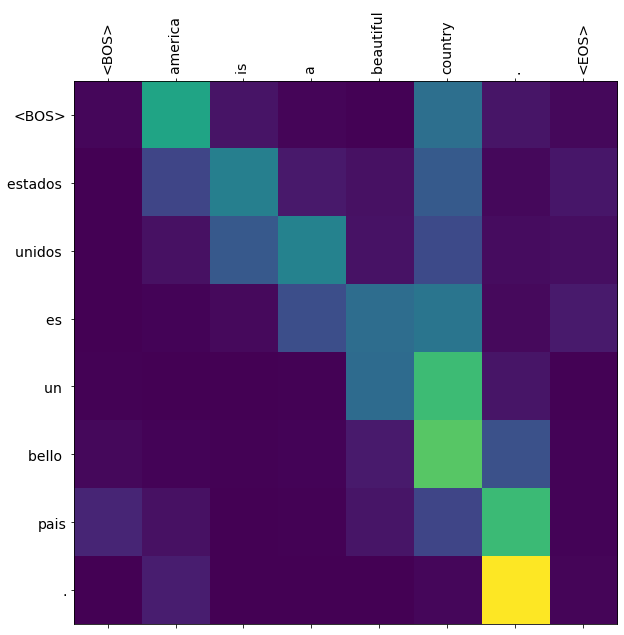

In [ ]:
inp_sentence = 'America is a beautiful country.'
translate(inp_sentence, decoder_Bahdanau)